In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('vertex_results.csv')
df = df.drop(['Forward turn', 'Reverse turn', 'Forward reason', 'Reverse reason'], axis=1)

In [ ]:
# Most logical visualization: a table?
# Unfortunately I made an error in coding so I lost the scores for the "forward" direction (the first is prop, the second is opp). I only have who won.
# I will use the scores from the reverse direction anyway, since running these experiments again will take too long

# Title: win rate against baseline (wrab)
# Rows: Flash, Pro
# Columns: Schema-guided, Multilayered

# Title: Schema-guided

Get the win rates against baseline

In [30]:
wcab = {} # Win count against baseline
wcab["flash"] = {"schema-guided": [0, 0], "enhanced": [0, 0]} # Win count against baseline flash, e.g. [count of schema wins, count of total schema-baseline matches]
wcab["pro"] = {"schema-guided": [0, 0], "enhanced": [0, 0]} # Win count against baseline pro

forward_map = {
    "Proposition": "First",
    "Opposition": "Second",
    "Tie": "Tie"
}
reverse_map = {
    "Proposition": "Second",
    "Opposition": "First",
    "Tie": "Tie"
}

for index, row in df.iterrows():
  model = row['Model']
  if row["First"] == "baseline": # If it's a baseline-X match, baseline is always the "First" listed
    forward_winner = row[forward_map[row["Forward winner"]]]
    reverse_winner = row[reverse_map[row["Reverse winner"]]]
    # print(forward_winner)

    won_forward = int(forward_winner == row["Second"]) # Did our non-baseline model win the forward?
    won_reverse = int(reverse_winner == row["Second"])

    wcab[model][row["Second"]][0] += won_forward + won_reverse

    # Add forward and reverse to total match count assuming there was a winner, not a tie
    forward_not_tie = int(forward_winner != "Tie")
    reverse_not_tie = int(reverse_winner != "Tie")
    if (not forward_not_tie) or (not reverse_not_tie):
      print(f"Check {index} for tie")
    wcab[model][row["Second"]][1] += forward_not_tie + reverse_not_tie

wrab = {"flash": {}, "pro": {}} # Win rate against baseline

for model in wcab.keys():
  for arch in wcab[model].keys():
    wrab[model][arch] = wcab[model][arch][0] / wcab[model][arch][1]

In [32]:
wcab

{'flash': {'schema-guided': [2, 18], 'enhanced': [2, 18]},
 'pro': {'schema-guided': [1, 18], 'enhanced': [1, 18]}}

In [31]:
wrab

{'flash': {'schema-guided': 0.1111111111111111,
  'enhanced': 0.1111111111111111},
 'pro': {'schema-guided': 0.05555555555555555,
  'enhanced': 0.05555555555555555}}

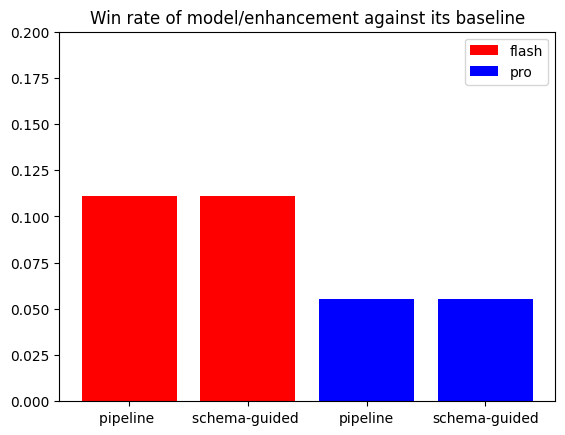

In [56]:
models = ["flash", "pro"]
architectures = ["enhanced", "schema-guided"]
plt.ylim(0.0, 0.2)
plt.title("Win rate of model/enhancement against its baseline")
handles = []
for model in models:
  for arch in architectures:
    arch_name = arch
    if arch == "enhanced":
      arch_name = "pipeline" # A slightly clearer name
    if model == "flash":
      color = "red"
      name = arch_name + " "
    else:
      color = "blue"
      name = arch_name
    plt.bar(name, wrab[model][arch], color=color)

# Custom legend because I'm too tired to figure out syntax for the normal route
from matplotlib.patches import Patch
custom_handles = [
        Patch(facecolor='red', label='flash'),
        Patch(facecolor='blue', label='pro')
]
plt.legend(handles=custom_handles, loc='upper right')

plt.show()

Get the average scores for each architecture over each turn

In [66]:
# Note: Because of a coding error, we only have the actual scores from the reverse order:
# Where "First prop scores" is in fact the proposition scores of the second model
# And "Second opp scores" is in fact the opposition scores of the first model
import numpy as np
scores_dict = {}

def array_string_to_array(array_string):
  array = np.array([int(x) for x in array_string.strip("[]").split(",")])
  return array

for index, row in df.iterrows():
  model = row['Model']
  if model not in scores_dict:
    scores_dict[model] = {}

  first_arch = row["First"]
  second_arch = row["Second"]
  if first_arch not in scores_dict[model]:
    scores_dict[model][first_arch] = [] # List of list of scores for each match this model/architecture was used in, for each turn
  if second_arch not in scores_dict[model]:
    scores_dict[model][second_arch] = []
  scores_dict[model][first_arch].append(array_string_to_array(row["Second opp scores"]))
  scores_dict[model][second_arch].append(array_string_to_array(row["First prop scores"]))

In [69]:
avg_scores_over_turns = {}
for model in scores_dict.keys():
  for arch in scores_dict[model].keys():
    scores_dict[model][arch] = np.array(scores_dict[model][arch], dtype=np.int32) # Rows are the matches. Columns are the turns
    avg_per_turn = np.mean(scores_dict[model][arch], axis=0)
    new_array = np.append(avg_per_turn, np.mean(avg_per_turn)) # Add fourth item, which is the average across all turns
    avg_scores_over_turns[model + " " + arch] = new_array

In [70]:
avg_scores_over_turns

{'flash baseline': array([79.44444444, 77.77777778, 75.66666667, 77.62962963]),
 'flash schema-guided': array([76.38888889, 74.38888889, 65.05555556, 71.94444444]),
 'flash enhanced': array([77.83333333, 78.22222222, 69.        , 75.01851852]),
 'pro baseline': array([80.88888889, 80.44444444, 79.33333333, 80.22222222]),
 'pro schema-guided': array([78.16666667, 75.94444444, 74.72222222, 76.27777778]),
 'pro enhanced': array([78.66666667, 78.38888889, 75.44444444, 77.5       ])}

In [72]:
flash_base = avg_scores_over_turns["flash baseline"]
flash_schema = avg_scores_over_turns["flash schema-guided"]
flash_enhanced = avg_scores_over_turns["flash enhanced"]

pro_base = avg_scores_over_turns["pro baseline"]
pro_schema = avg_scores_over_turns["pro schema-guided"]
pro_enhanced = avg_scores_over_turns["pro enhanced"]

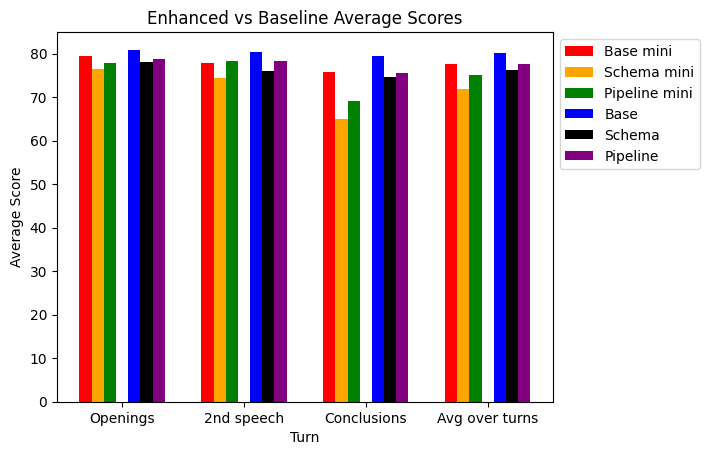

In [75]:
# Plot
turns = ['Openings', '2nd speech', 'Conclusions', 'Avg over turns']
x = [0, 1, 2, 3]

# plt.figure(figsize=(10, 6))

bar_width = 0.1
plt.bar([i - 0.3 for i in x], flash_base, width=bar_width, color='red', label='Base mini')
plt.bar([i - 0.2 for i in x], flash_schema, width=bar_width, color='orange', label='Schema mini')
plt.bar([i - 0.1 for i in x], flash_enhanced, width=bar_width, color='green', label='Pipeline mini')
# Slight gap between models
plt.bar([i + 0.1 for i in x], pro_base, width=bar_width, color='blue', label='Base')
plt.bar([i + 0.2 for i in x], pro_schema, width=bar_width, color='black', label='Schema')
plt.bar([i + 0.3 for i in x], pro_enhanced, width=bar_width, color='purple', label='Pipeline')


plt.xlabel('Turn')
plt.ylabel('Average Score')
plt.title('Enhanced vs Baseline Average Scores')
plt.xticks(x, turns)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [5]:
df

,Motion,Model,First,Second,Forward winner,Reverse winner,First prop scores,Second opp scores
0,This House Believes that developing countries ...,flash,baseline,schema-guided,Proposition,Opposition,"[80, 77, 60]","[83, 82, 78]"
1,This House Believes that developing countries ...,flash,baseline,enhanced,Proposition,Opposition,"[80, 77, 60]","[83, 82, 78]"
2,This House Believes that developing countries ...,flash,schema-guided,enhanced,Proposition,Proposition,"[78, 80, 77]","[76, 60, 60]"
3,This House Believes that developing countries ...,pro,baseline,schema-guided,Opposition,Opposition,"[78, 75, 74]","[80, 78, 81]"
4,This House Believes that developing countries ...,pro,baseline,enhanced,Opposition,Opposition,"[78, 75, 74]","[80, 78, 81]"
5,This House Believes that developing countries ...,pro,schema-guided,enhanced,Proposition,Proposition,"[79, 78, 80]","[77, 68, 72]"
6,This House regrets the norm of association bet...,flash,baseline,schema-guided,Proposition,Opposition,"[78, 76, 60]","[80, 79, 78]"
7,This House regrets the norm of association bet...,flash,baseline,enhanced,Proposition,Opposition,"[78, 76, 60]","[80, 79, 78]"
8,This House regrets the norm of association bet...,flash,schema-guided,enhanced,Proposition,Proposition,"[78, 80, 75]","[74, 62, 60]"
9,This House regrets the norm of association bet...,pro,baseline,schema-guided,Proposition,Opposition,"[78, 75, 74]","[80, 79, 78]"


# Debugging

In [33]:
wcab = {} # Win count against baseline
wcab["flash"] = {"schema-guided": [0, 0], "enhanced": [0, 0]} # Win count against baseline flash, e.g. [count of schema wins, count of total schema-baseline matches]
wcab["pro"] = {"schema-guided": [0, 0], "enhanced": [0, 0]} # Win count against baseline pro

forward_map = {
    "Proposition": "First",
    "Opposition": "Second",
    "Tie": "Tie"
}
reverse_map = {
    "Proposition": "Second",
    "Opposition": "First",
    "Tie": "Tie"
}

pro_count = 0
for index, row in df.iterrows():
  model = row['Model']
  if row["First"] != "baseline":
    if row["First"] != "schema-guided":
      print(f"Check value of first at {index}")
  if row["Second"] != "schema-guided":
    if row["Second"] != "enhanced":
      print(f"Check value of second at {index}")
  if row["Forward winner"] != "Proposition" and row["Forward winner"] != "Opposition":
    print(f"Check value of forward winner at {index}")
  if row["Reverse winner"] != "Proposition" and row["Reverse winner"] != "Opposition":
    print(f"Check value of reverse winner at {index}")

In [34]:
wcab = {} # Win count against baseline
wcab["flash"] = {"schema-guided": [0, 0], "enhanced": [0, 0]} # Win count against baseline flash, e.g. [count of schema wins, count of total schema-baseline matches]
wcab["pro"] = {"schema-guided": [0, 0], "enhanced": [0, 0]} # Win count against baseline pro

forward_map = {
    "Proposition": "First",
    "Opposition": "Second",
    "Tie": "Tie"
}
reverse_map = {
    "Proposition": "Second",
    "Opposition": "First",
    "Tie": "Tie"
}

pro_count = 0
for index, row in df.iterrows():
  model = row['Model']
  if row["First"] == "baseline": # If it's a baseline-X match, baseline is always the "First" listed
    forward_winner = row[forward_map[row["Forward winner"]]]
    reverse_winner = row[reverse_map[row["Reverse winner"]]]

    # print(forward_winner)

    won_forward = int(forward_winner == row["Second"]) # Did our non-baseline model win the forward?
    won_reverse = int(reverse_winner == row["Second"])

    wcab[model][row["Second"]][0] += won_forward + won_reverse

    # Add forward and reverse to total match count assuming there was a winner, not a tie
    forward_not_tie = int(forward_winner != "Tie")
    reverse_not_tie = int(reverse_winner != "Tie")
    if (not forward_not_tie) or (not reverse_not_tie):
      print(f"Check {index} for tie")
    wcab[model][row["Second"]][1] += forward_not_tie + reverse_not_tie

    # If model is pro, for debugging
    if model == "pro":
      if row["First"] == "baseline" and row["Second"] == "enhanced":
        pro_count += 1
        # print(str(index) + "\n")
        print(forward_winner)
        print(reverse_winner)
print(pro_count)
wrab = {"flash": {}, "pro": {}} # Win rate against baseline

for model in wcab.keys():
  for arch in wcab[model].keys():
    wrab[model][arch] = wcab[model][arch][0] / wcab[model][arch][1]


enhanced
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
baseline
9


In [35]:
wcab
# Why are thre only 18 total? Turns out we had 9 motions, not 10 as I'd thought

{'flash': {'schema-guided': [2, 18], 'enhanced': [2, 18]},
 'pro': {'schema-guided': [1, 18], 'enhanced': [1, 18]}}

# Visualizations for the sanity check experiments

In [76]:
df = pd.read_csv('sanitycheck.csv')

In [77]:
df

,Motion,Flash role,Prop role,Winner,Flash scores,Pro scores,Turns,Reason
0,This House Believes that developing countries ...,Proposition,Opposition,Pro,"[78, 76, 74]","[80, 82, 79]","[Turn(speaker_position='prop_1', team='Proposi...",1. Employment & Inclusivity (largest clash) •...
1,This House regrets the norm of association bet...,Opposition,Proposition,Pro,"[79, 77, 76]","[82, 83, 80]","[Turn(speaker_position='prop_1', team='Proposi...",1. Core Clash – Is harm baked into the norm o...
2,This House believes that China should pursue a...,Proposition,Opposition,Pro,"[77, 75, 72]","[82, 80, 78]","[Turn(speaker_position='prop_1', team='Proposi...",1. Argumentation & Analysis (45 %) • Economic...
3,This House opposes the expectation that romant...,Opposition,Proposition,Pro,"[80, 77, 76]","[80, 79, 78]","[Turn(speaker_position='prop_1', team='Proposi...",1. Definition & Burden of Proof – Prop 1 set ...
4,This House would heavily ease labour regulatio...,Proposition,Opposition,Pro,"[76, 78, 77]","[80, 82, 81]","[Turn(speaker_position='prop_1', team='Proposi...",1. Central Clash – Aggregate Demand vs. Labou...
5,This House regrets the glorification of the ca...,Opposition,Proposition,Pro,"[77, 75, 74]","[78, 76, 77]","[Turn(speaker_position='prop_1', team='Proposi...","1. Definition & Burden – Prop 1 gave a clear,..."
6,This House believes that works of modern ficti...,Proposition,Opposition,Pro,"[77, 75, 72]","[80, 78, 77]","[Turn(speaker_position='prop_1', team='Proposi...",1. Argumentation & Analysis (45%) • Proposit...
7,This House opposes the norm to prefer the natu...,Opposition,Proposition,Pro,"[79, 78, 77]","[82, 80, 78]","[Turn(speaker_position='prop_1', team='Proposi...",1. Argumentation & Analysis • Proposition set...
8,This House believes that education systems sho...,Proposition,Opposition,Pro,"[78, 75, 74]","[81, 80, 78]","[Turn(speaker_position='prop_1', team='Proposi...",1. Argumentation & Analysis • Learning Outcom...


In [79]:
flash_scores = []
pro_scores = []
for index, row in df.iterrows():
  flash_scores.append(array_string_to_array(row["Flash scores"]))
  pro_scores.append(array_string_to_array(row["Pro scores"]))

np.mean(flash_scores), np.mean(pro_scores)

(np.float64(76.25925925925925), np.float64(79.66666666666667))